<a href="https://colab.research.google.com/github/gmazzitelli/studenti/blob/master/covid19.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
# download updated data
# repository italy https://github.com/pcm-dpc/COVID-19/tree/master/dati-andamento-nazionale
url_csv_file = "https://raw.githubusercontent.com/pcm-dpc/COVID-19/master/dati-andamento-nazionale/dpc-covid19-ita-andamento-nazionale.csv"
df = pd.read_csv(url_csv_file)

In [15]:
df.head() # show firt line

,data,stato,ricoverati_con_sintomi,terapia_intensiva,totale_ospedalizzati,isolamento_domiciliare,totale_attualmente_positivi,nuovi_attualmente_positivi,dimessi_guariti,deceduti,totale_casi,tamponi
0,2020-02-24 18:00:00,ITA,101,26,127,94,221,221,1,7,229,4324
1,2020-02-25 18:00:00,ITA,114,35,150,162,311,90,1,10,322,8623
2,2020-02-26 18:00:00,ITA,128,36,164,221,385,74,3,12,400,9587
3,2020-02-27 18:00:00,ITA,248,56,304,284,588,203,45,17,650,12014
4,2020-02-28 18:00:00,ITA,345,64,409,412,821,233,46,21,888,15695


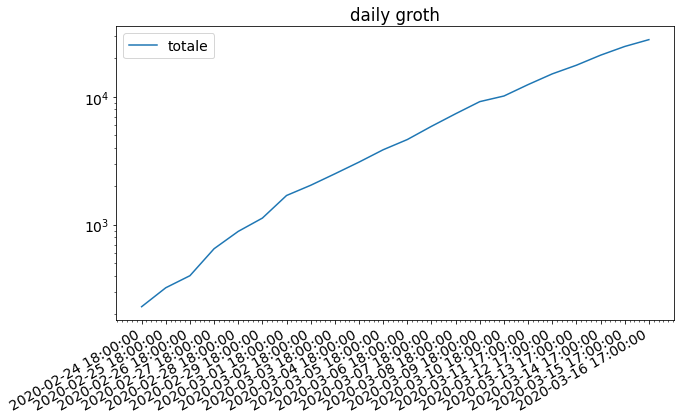

In [41]:
# makes plots
plt.style.use('fast')
plt.rc('font', size = 14, family ='Sans-Serif')
fig, ax = plt.subplots(figsize=(10,6))
fig.autofmt_xdate()
ax.plot(df['data'], df['totale_casi'], label='totale')
ax.fmt_xdata = mdates.DateFormatter('%Y-%m-%d')
ax.set_title('daily groth')
ax.set_yscale('log')
ax.legend(loc=2)
plt.minorticks_on()
plt.show()